In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# !pip install geopandas shapely mapclassify
import geopandas as gpd
from shapely.geometry import Polygon
import mapclassify
import os
pd.set_option("display.max_columns", 99)
os.chdir("/home/joosungm/projects/def-lelliott/joosungm/projects/ssc23-case-comp/")
# os.chdir("/content/drive/MyDrive/projects/ssc23-case-comp")

SystemError: initialization of _internal failed without raising an exception

In [ ]:
# Merge all the data

prov_short = ["AB", "BC", "MB", "NB", "NL", "NS", "ON", "PE", "QC", "SK"]
prov_long = ["Alberta", "British_Columbia", "Manitoba", "New_Brunswick", 
             "Newfoundland_and_Labrador", "Nova_Scotia", "Ontario", 
             "Prince_Edward_Island", "Quebec", "Saskatchewan"]

geo_df = pd.DataFrame()
prod_temp = pd.DataFrame()
iv_prov = pd.DataFrame()

for i, prov in enumerate(prov_short):
    # i_prov = 0
    
    # - geometry data
    temp_geo_filename = "./data/geojson_files/1.a_census_data_" + prov + "_CSD_geometry_only.geojson"
    temp_geo_df = gpd.read_file(temp_geo_filename)
    geo_df = pd.concat([geo_df, temp_geo_df], axis = 0)

    # - prod_temp data
    temp_prod_temp_filename = "./data/user_data/01_iv_analysis/" + prov + "/prod_temp.csv"
    temp_prod_temp = pd.read_csv(temp_prod_temp_filename)
    prod_temp = pd.concat([prod_temp, temp_prod_temp], axis = 0)

    # - iv result data
    temp_iv_filename = "./data/user_data/01_iv_analysis/" + prov + "/tavg_log_iv2sls_result.csv"
    temp_iv = pd.read_csv(temp_iv_filename)
    temp_iv["provincename"] = prov_long[i]
    iv_prov = pd.concat([iv_prov, temp_iv], axis = 0)
    
geo_df.to_csv("./data/user_data/01_iv_analysis/C01_geo_df.csv", index = False)
prod_temp.to_csv("./data/user_data/01_iv_analysis/C01_prod_temp.csv", index = False)
iv_prov.to_csv("./data/user_data/01_iv_analysis/C01_iv_prov.csv", index = False)

In [2]:
# Load data
geo_df = pd.read_csv("./data/user_data/01_iv_analysis/C01_geo_df.csv")
# - replace " " with "_" in provincename column in geo_df
geo_df["provincename"] = geo_df["provincename"].str.replace(" ", "_")

prod_temp = pd.read_csv("./data/user_data/01_iv_analysis/C01_prod_temp.csv")
iv_prov = pd.read_csv("./data/user_data/01_iv_analysis/C01_iv_prov.csv")
iv_all = pd.read_csv("./data/user_data/01_iv_analysis/_allTogether/tavg_iv2sls_result.csv")

print(geo_df.shape)
# print(geo_df.columns)

print(prod_temp.shape)
# print(prod_temp.columns)

print(iv_prov.shape)
# print(iv_prov.columns)

print(iv_all.shape)
# print(iv_all.columns)

# - Load province and CSD boundaries (from Statistics Canada)
prov_shapefile = './data/user_data/_other/lpr_000b21a_e.shp'
province = gpd.read_file(prov_shapefile)
province = province.iloc[0:10, :]

csd_shapefile = './data/user_data/_other/lcsd000b21a_e.shp'
csd = gpd.read_file(csd_shapefile)

(5054, 4)
(1516200, 32)
(140, 6)
(14, 5)


DriverError: ./data/user_data/_other/lcsd000b21a_e.shp: No such file or directory

In [125]:
prod_temp_sub = prod_temp.loc[prod_temp.month == 12, 
    ["GeoUID", "Dominant_NAICS"]].drop_duplicates().sort_values(
        by = "GeoUID").reset_index(drop = True)

merged_data = geo_df.merge(
    right = prod_temp_sub, 
    on = "GeoUID", how = "left").drop_duplicates().reset_index(
        drop = True).merge(
            right = iv_prov, 
            left_on = ["provincename", "Dominant_NAICS"], 
            right_on = ["provincename", "industry"], 
            how = "left").sort_values(
                by = "GeoUID").drop(
                    columns = ["industry"])

# - is_sig == True if all of pval(param), pval(overid), pval(endog) < 0.05
merged_data["is_sig"] = (merged_data["pval(param)"] < 0.05) & (merged_data["pval(overid)"] < 0.05) & (merged_data["pval(endog)"] < 0.05)

# - If GeoUID is repeated, then choose the one with is_sig == True and the largest pval(param)
merged_data = merged_data.sort_values(
    by = ["GeoUID", "is_sig", "pval(param)"], 
    ascending = [True, False, True]).drop_duplicates(
        subset = "GeoUID", keep = "first").reset_index(drop = True)

# - If is_sig == False, then param = 0
merged_data.loc[merged_data.is_sig == False, "param"] = 0

# - Change the data type of GeoUID to str
merged_data["GeoUID"] = merged_data["GeoUID"].astype(str)

print(merged_data.shape)
# merged_data.sample(5)

(5054, 10)


In [152]:
country_data = merged_data.copy()

# - Add boundary data for the census subdivisions.
country_data = country_data.drop(columns = "geometry").merge(
    right = csd[["CSDUID", "geometry"]], 
    left_on = "GeoUID", right_on = "CSDUID", how = "left").drop(
        columns = "CSDUID").reset_index(
        drop = True)

# - Make GeoDataFrame.
country_data = gpd.GeoDataFrame(country_data, 
                                geometry = "geometry", crs = "EPSG:3347")

# - Assign categories by param(\beta_{tavg}: 
#   the effect of a unit increase in tavg on log(production)).
group_labels = [" < -0.3)", "[-0.3, -0.15)", "[-0.15, 0)", "[0, 0.15)", "[0.15, 0.3)", "[0.3 < "]
country_data.loc[pd.isnull(country_data["Dominant_NAICS"]), "param"] = None
country_data["group"] = pd.cut(country_data["param"], 
                               (-0.7, -0.3, -0.15, 0, 0.15, 0.3, 0.5), 
                               labels = group_labels, right = False)

# - If param == NaN then group = NaN
country_data.sample(5)

,GeoUID,Region.Name,provincename,Dominant_NAICS,param,pval(param),pval(overid),pval(endog),is_sig,geometry,group
1815,2480037,Papineauville (MÉ),Quebec,X31.33.Manufacturing,0.150,0.0,0.0,0.0,True,"POLYGON ((7519773.797 1235070.091, 7519821.486...","[0.15, 0.3)"
1149,2427055,Saint-Jules (PE),Quebec,X11.Agriculture.forestry.fishing.hunting.21.Mi...,-0.029,0.0,0.0,0.0,True,"POLYGON ((7802741.314 1389596.117, 7804198.683...","[-0.15, 0)"
3259,4706820,Wa-Pii Moos-Toosis (White Calf) 83A (IRI),Saskatchewan,X31.33.Manufacturing,0.045,0.0,0.0,0.0,True,"MULTIPOLYGON (((5374678.691 1701367.920, 53746...","[0, 0.15)"
2835,4616046,Valley River 63A (IRI),Manitoba,X91.Public.administration,-0.066,0.0,0.0,0.0,True,"POLYGON ((5577792.180 1723230.457, 5577025.923...","[-0.15, 0)"
3590,4713076,Senlac No. 411 (RM),Saskatchewan,X11.Agriculture.forestry.fishing.hunting.21.Mi...,0.397,0.0,0.0,0.0,True,"POLYGON ((5029850.934 1998577.400, 5032103.060...",[0.3 <


In [162]:
# most negatively affected
print(merged_data[["Region.Name", "provincename", "Dominant_NAICS", "param"]].sort_values(
    by = "param").head(5))

# most positively affected
print(merged_data[["Region.Name", "provincename", "Dominant_NAICS", "param"]].sort_values(
    by = "param").tail(5))

                Region.Name          provincename        Dominant_NAICS  param
573   Chapel Island 5 (IRI)           Nova_Scotia         X22.Utilities -0.674
555             Trenton (T)           Nova_Scotia         X22.Utilities -0.674
400            Lot 39 (LOT)  Prince_Edward_Island  X31.33.Manufacturing -0.556
432       Breadalbane (COM)  Prince_Edward_Island  X31.33.Manufacturing -0.556
452  Bedeque and Area (COM)  Prince_Edward_Island  X31.33.Manufacturing -0.556
                    Region.Name  provincename  \
3249      Tullymet No. 216 (RM)  Saskatchewan   
3250            Piapot 75 (IRI)  Saskatchewan   
3252  Standing Buffalo 78 (IRI)  Saskatchewan   
3242         Cupar No. 218 (RM)  Saskatchewan   
3522        Milden No. 286 (RM)  Saskatchewan   

                                         Dominant_NAICS  param  
3249  X11.Agriculture.forestry.fishing.hunting.21.Mi...  0.397  
3250  X11.Agriculture.forestry.fishing.hunting.21.Mi...  0.397  
3252  X11.Agriculture.forestry.fishi

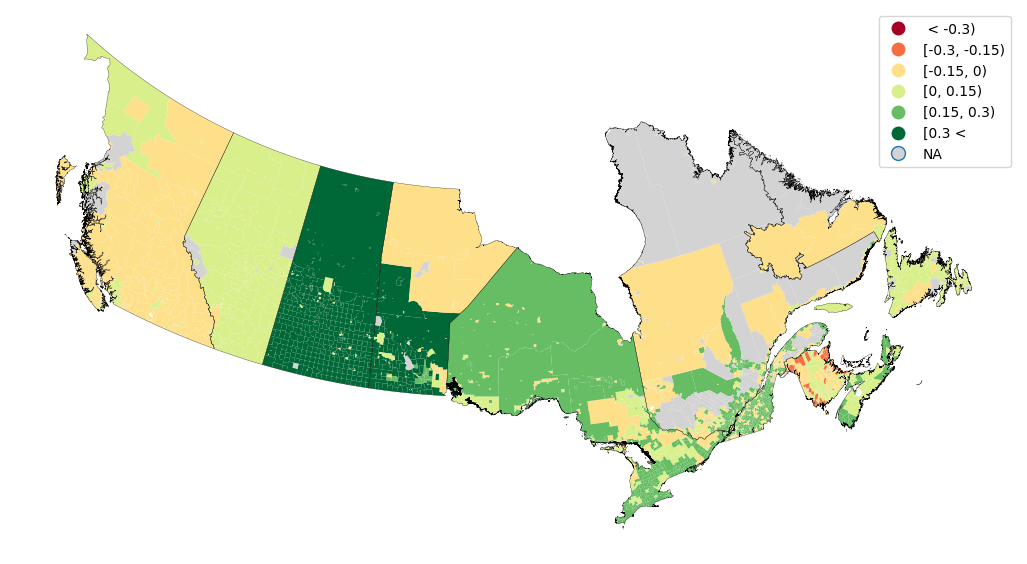

In [159]:
fig, ax = plt.subplots(1, 1, figsize = (13, 13))

ax.set_aspect("equal")
province.plot(
    ax = ax,
    edgecolor = "black", 
    facecolor = "none",
    # color = "lightgrey",
    linewidth = 0.2,
    zorder = 2)

country_data.plot(
    column = "group",
    ax = ax, 
    cmap = "RdYlGn", alpha = 1, linewidth = 1,
    zorder = 1,
    legend = True,
    missing_kwds={
        "color": "lightgrey",
        "label": "NA",
    }
    )

# ax.set_title("TBD")
ax.axis("off")
plt.show()

In [160]:
fig.savefig("./figs/iv_result.png", dpi = 300, transparent = False)
fig.savefig("./figs/iv_result2.png", dpi = 300, transparent = True)

In [11]:
iv_prov = pd.read_csv("/home/joosungm/projects/def-lelliott/joosungm/projects/ssc23-case-comp/data/user_data/01_iv_analysis/C01_iv_prov.csv")
prov_names = iv_prov.provincename.unique()
print(prov_names)
industry_names = iv_prov.industry.unique()
print(industry_names)

['Alberta' 'British_Columbia' 'Manitoba' 'New_Brunswick'
 'Newfoundland_and_Labrador' 'Nova_Scotia' 'Ontario'
 'Prince_Edward_Island' 'Quebec' 'Saskatchewan']
['X22.Utilities' 'X23.Construction' 'X31.33.Manufacturing'
 'X48.49.Transportation.and.warehousing' 'X61.Educational.services'
 'X62.Health.care.and.social.assistance'
 'X72.Accommodation.and.food.services'
 'X81.Other.services..except.public.administration.'
 'X91.Public.administration'
 'X11.Agriculture.forestry.fishing.hunting.21.Mining.quarrying.and.oil.and.gas.extraction'
 'X41.Wholesale.trade.44.45.Retail.trade'
 'X52.Finance.and.insurance.53.Real.estate.and.rental.and.leasing'
 'X54.Professional..scientific.and.technical.services.55.56'
 'X51.Information.culture.and.recreation.71']


In [7]:
iv_prov.loc[iv_prov.provincename == "British_Columbia", ]

,industry,param,pval(param),pval(overid),pval(endog),provincename
14,X22.Utilities,-0.041,0.0,0.0,0.000,British_Columbia
15,X23.Construction,-0.004,0.0,0.0,0.000,British_Columbia
16,X31.33.Manufacturing,-0.016,0.0,0.0,0.000,British_Columbia
17,X48.49.Transportation.and.warehousing,-0.011,0.0,0.0,0.000,British_Columbia
18,X61.Educational.services,0.003,0.0,0.0,0.005,British_Columbia
19,X62.Health.care.and.social.assistance,0.024,0.0,0.0,0.000,British_Columbia
20,X72.Accommodation.and.food.services,0.020,0.0,0.0,0.000,British_Columbia
21,X81.Other.services..except.public.administration.,0.003,0.0,0.0,0.202,British_Columbia
22,X91.Public.administration,0.002,0.0,0.0,0.025,British_Columbia
23,X11.Agriculture.forestry.fishing.hunting.21.Mi...,-0.092,0.0,0.0,0.000,British_Columbia


In [26]:
bonferroni_pval = 0.05 / len(prov_names)
prov_name = prov_names[0]

iv_new = pd.DataFrame({"industry":industry_names})

for prov_name in prov_names:
    iv_sub = iv_prov.loc[iv_prov["provincename"] == prov_name, ]

    # # - 
    iv_sub["is_sig"] = np.where(iv_sub["pval(param)"] < bonferroni_pval, True, False)
    iv_sub[prov_name] = np.where(iv_sub["is_sig"] == True, iv_sub["param"], 0)
    iv_new = pd.merge(iv_new, iv_sub.loc[:, ["industry", prov_name]], on = "industry", how = "left")

iv_table = iv_new[["industry", "British_Columbia", "Alberta", "Saskatchewan", "Manitoba", "Ontario", "Quebec", "New_Brunswick", "Nova_Scotia", "Prince_Edward_Island", "Newfoundland_and_Labrador"]]

iv_table.to_csv("./data/user_data/01_iv_analysis/A04_iv_table.csv", index = False)
display(iv_table)

/tmp/ipykernel_1604498/1475923064.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iv_sub["is_sig"] = np.where(iv_sub["pval(param)"] < bonferroni_pval, True, False)
/tmp/ipykernel_1604498/1475923064.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iv_sub[prov_name] = np.where(iv_sub["is_sig"] == True, iv_sub["param"], 0)
/tmp/ipykernel_1604498/1475923064.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

,industry,British_Columbia,Alberta,Saskatchewan,Manitoba,Ontario,Quebec,New_Brunswick,Nova_Scotia,Prince_Edward_Island,Newfoundland_and_Labrador
0,X22.Utilities,-0.041,-0.048,0.055,-0.107,-0.019,-0.102,0.120,-0.674,0.000,-0.047
1,X23.Construction,-0.004,0.005,0.028,0.069,0.051,0.060,0.126,-0.215,-0.031,0.048
2,X31.33.Manufacturing,-0.016,0.079,0.045,0.154,0.155,0.150,-0.187,0.727,-0.556,0.086
3,X48.49.Transportation.and.warehousing,-0.011,0.000,0.073,0.049,0.014,0.012,0.111,-0.066,0.174,0.052
4,X61.Educational.services,0.003,-0.035,-0.040,-0.059,-0.040,-0.046,0.019,-0.205,0.062,-0.016
5,X62.Health.care.and.social.assistance,0.024,0.028,-0.002,0.026,-0.027,-0.056,-0.054,0.157,0.050,0.026
6,X72.Accommodation.and.food.services,0.020,0.017,0.029,0.017,-0.007,-0.017,0.070,0.000,0.100,0.008
7,X81.Other.services..except.public.administration.,0.003,0.000,0.062,0.066,0.017,0.000,0.042,0.200,0.105,0.012
8,X91.Public.administration,0.002,-0.084,-0.061,-0.066,-0.089,-0.115,0.100,0.120,0.072,-0.047
9,X11.Agriculture.forestry.fishing.hunting.21.Mi...,-0.092,0.036,0.397,0.300,0.072,-0.029,-0.062,0.235,-0.347,0.035
